Note that steps 1-3 of this strategy were executed in terminal. This notebook continues from steps 4-6.

# Setup

In [1]:
%reload_ext autoreload

# Imports
from os.path import join
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Constants
BASELINE_PATH = join('data', 'baseline_coverage.txt')
MODIFIED_PATH = join('data', 'modified_coverage.txt')
ANNOTATIONS_PATH = join('data', 'toy_genome_genes.bed')
COLUMNS = ['chromosome', 'position', 'depth']
ANNOTATIONS_COLUMNS = ['genome', 'start', 'end', 'gene', 'score', 'half-strand']

# Preliminaries
First, we open the coverage files generated in step 3.

In [2]:
baseline_coverage = pd.read_csv(BASELINE_PATH, sep='\t', header=None, names=COLUMNS)
modified_coverage = pd.read_csv(MODIFIED_PATH, sep='\t', header=None, names=COLUMNS)

At this point, it's worth visualising the coverage distributions to see better understand them. Doing so will also give us clues on how to normalise them.

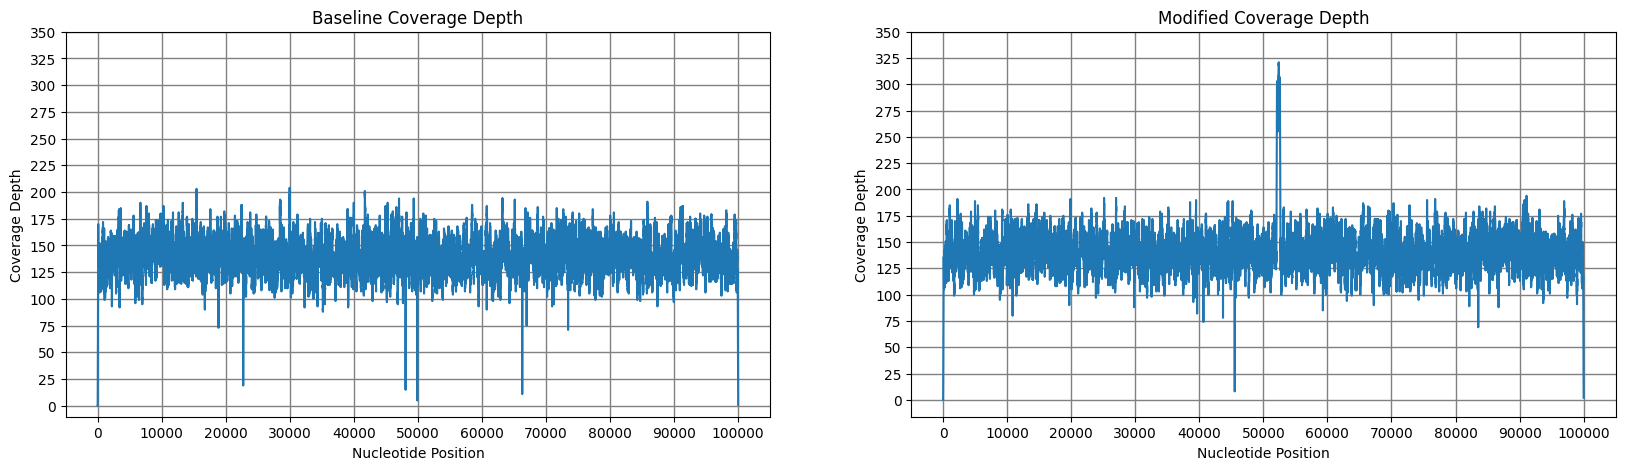

In [3]:
fig = plt.figure(figsize=(20, 5))
xticks = np.arange(0, len(baseline_coverage)+1, 10000)
yticks = np.arange(0, 351, 25)

ax0 = fig.add_subplot(1,2,1)
plt.plot(baseline_coverage['depth'])
ax0.set_title("Baseline Coverage Depth")
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(color='gray', linestyle='-', linewidth=1)
ax0.set_xlabel('Nucleotide Position')
ax0.set_ylabel('Coverage Depth')

ax1 = fig.add_subplot(1,2,2)
plt.plot(modified_coverage['depth'])
ax1.set_title("Modified Coverage Depth")
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.set_xlabel('Nucleotide Position')
ax1.set_ylabel('Coverage Depth')
ax1.grid(color='gray', linestyle='-', linewidth=1)

plt.show()

Both figures are noisy and approximately uniformly distributed, which suggests that a simple mean normalization is sensible for this application. There are also some outliers in both distributions with considerably lower depths, which will affect later calculations. We can address both of these issues by treating the distribution as a digital signal and appyling noise reduction techniques. A simple Savitzky-Golay filter will suffice.

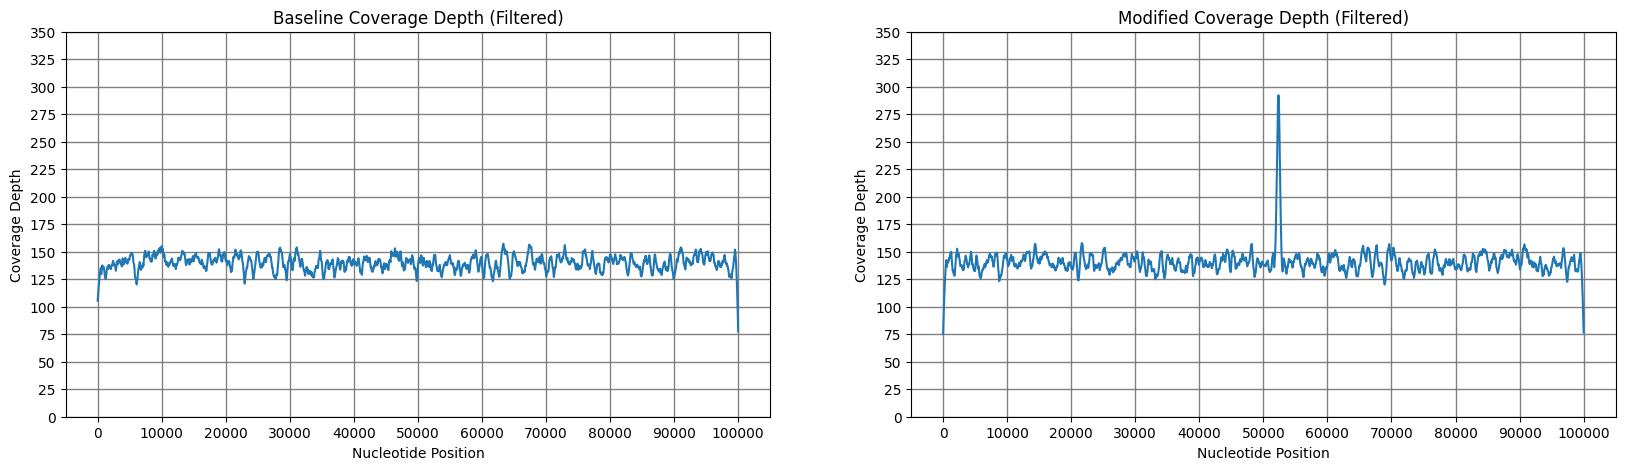

In [4]:
filter_window = 1000
filter_poly_order = 2

fil_baseline_cov = savgol_filter(baseline_coverage['depth'], filter_window, filter_poly_order)
fil_modified_cov = savgol_filter(modified_coverage['depth'], filter_window, filter_poly_order)

fig = plt.figure(figsize=(20, 5))
xticks = np.arange(0, len(fil_baseline_cov)+1, 10000)
yticks = np.arange(0, 351, 25)

ax0 = fig.add_subplot(1,2,1)
plt.plot(fil_baseline_cov)
ax0.set_title("Baseline Coverage Depth (Filtered)")
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(color='gray', linestyle='-', linewidth=1)
ax0.set_xlabel('Nucleotide Position')
ax0.set_ylabel('Coverage Depth')

ax1 = fig.add_subplot(1,2,2)
plt.plot(fil_modified_cov)
ax1.set_title("Modified Coverage Depth (Filtered)")
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.set_xlabel('Nucleotide Position')
ax1.set_ylabel('Coverage Depth')
ax1.grid(color='gray', linestyle='-', linewidth=1)

plt.show()

The choice of parameters (window size and polynomial order) were not entirely arbitrary. A window size of 1000 allows the data to be summarized without being too compact and the shape of the graph doesn't change for polynomials of order 3-4. Though, the graph does a lose all expressiveness for higher orders. Thus, an order 2 polynomial is sufficient. Now that our outliers are gone and the distributions are less noisy we can proceed with normalization.

# Step 4: Normalize Coverage Distributions
Now we normalise the distributions so that we can compare them directly. We do so by dividing all values in each distribution by their respective means.

In [5]:
# Normalize by sample mean
baseline_coverage_norm = fil_baseline_cov / fil_baseline_cov.mean()
modified_coverage_norm = fil_modified_cov / fil_modified_cov.mean()

By visualising the normalized forms of the coverage distributions we can confirm if the choice of normalisation was reasonable.

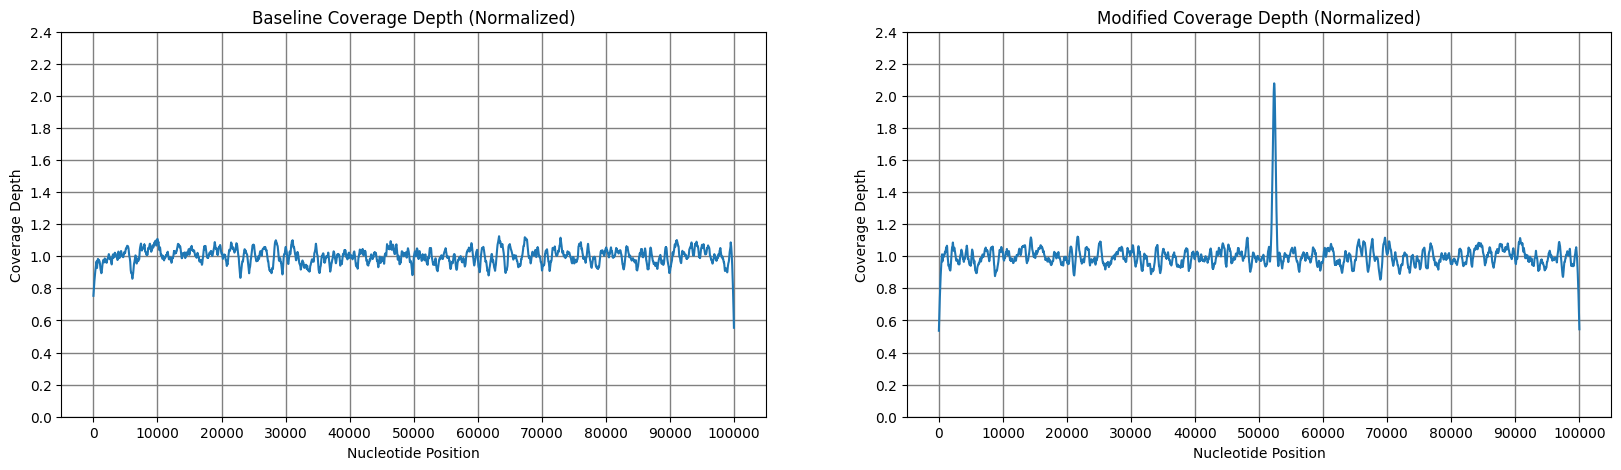

In [6]:
fig = plt.figure(figsize=(20, 5))
y_ticks = np.arange(0, 2.5, 0.2)
xticks = np.arange(0, len(baseline_coverage)+1, 10000)

ax0 = fig.add_subplot(1,2,1)
plt.plot(baseline_coverage_norm)
ax0.set_title("Baseline Coverage Depth (Normalized)")
ax0.set_yticks(y_ticks)
ax0.set_xticks(xticks)
ax0.grid(color='gray', linestyle='-', linewidth=1)
ax0.set_xlabel('Nucleotide Position')
ax0.set_ylabel('Coverage Depth')

ax1 = fig.add_subplot(1,2,2)
plt.plot(modified_coverage_norm)
ax1.set_title("Modified Coverage Depth (Normalized)")
ax1.set_yticks(y_ticks)
ax1.set_xticks(xticks)
ax1.set_xlabel('Nucleotide Position')
ax1.set_ylabel('Coverage Depth')
ax1.grid(color='gray', linestyle='-', linewidth=1)

The graphs have retained their general shape and their relative amplitudes are much smaller, this will make comparisons much easier. The distributions are now ready to be compared elementwise.

# Step 5: Determine Copy Number Gain
Now that the distributions are normalized we can determine the copy number gain for each. The gain will be calculated as the elementwise difference between the query (modified) distribution and the baseline ditribution and expressed as a factor of the baseline. The formula is as follows:

$$Gain\ =\ \frac{Coverage_{mod} - Coverage_{base}}{Coverage_{base}}$$

In [7]:
copy_no_gain_dist = (modified_coverage_norm - baseline_coverage_norm) / baseline_coverage_norm

Now to visualize the gain.

[]

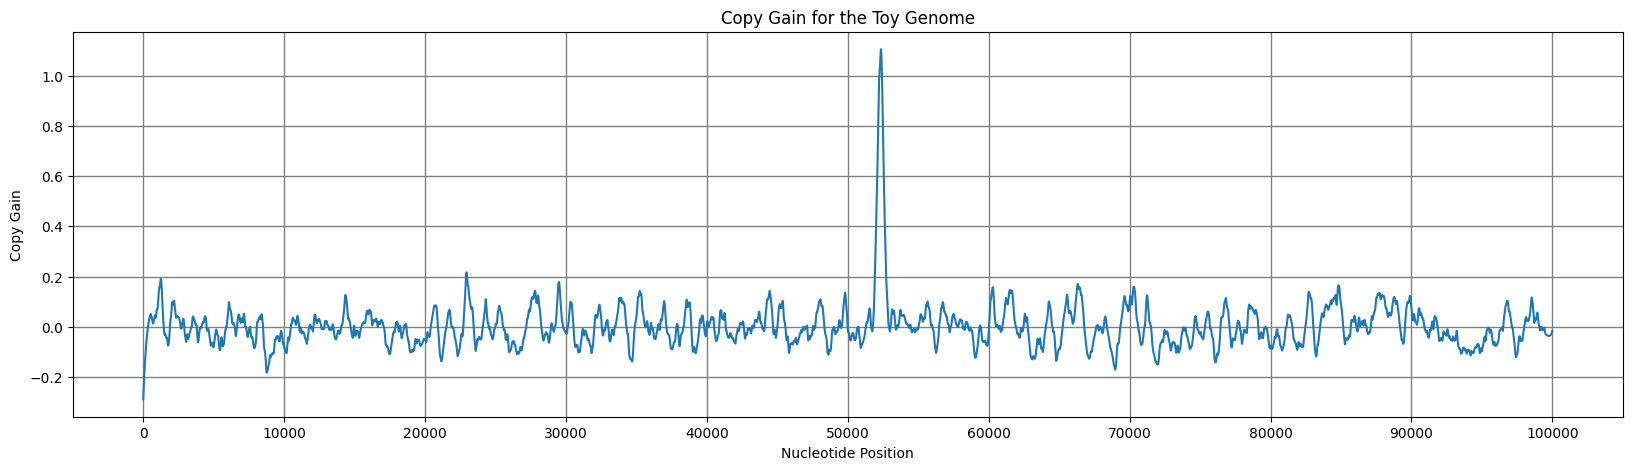

In [8]:
fig = plt.figure(figsize=(20, 5))
xticks = np.arange(0, len(baseline_coverage)+1, 10000)

plt.plot(copy_no_gain_dist)
plt.title("Copy Gain for the Toy Genome")
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.xlabel('Nucleotide Position')
plt.xticks(xticks)
plt.ylabel('Copy Gain')
plt.plot()

Now, the picture is quiet clear. Our region of interest lies in the 50'000th neighborhood, as suspected. An alternative, more visually appealing method for interpreting the copy gain would be to segment the copy gain graph in accordance with the gene annotations.

# Step 6: Region Extraction and Gene Correlation.

We extract the start and end of each gene as well as their names and map the mean gain per gene to a new distribution.

[]

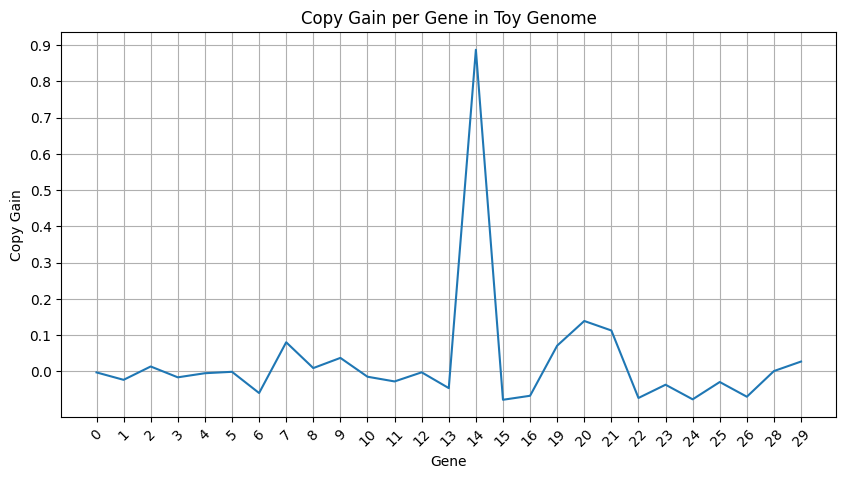

In [9]:
annotations = pd.read_csv(ANNOTATIONS_PATH, sep='\t', header=None, names=ANNOTATIONS_COLUMNS)

xticks = range(len(annotations))
xlabels = []
copy_gain_alt = []

for id, item in annotations.iterrows():
    start = item['start']
    end = item['end']
    gene = item['gene']
    copy_gain_alt.append(copy_no_gain_dist[start: end].mean())
    xlabels.append(gene.replace('gene_', ''))

fig = plt.figure(figsize=(10,5))

plt.plot(copy_gain_alt)
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(xticks, labels=xlabels, rotation=45)
plt.grid()
plt.title('Copy Gain per Gene in Toy Genome')
plt.ylabel('Copy Gain')
plt.xlabel('Gene')
plt.plot()

Now it couldn't be more simple! We inspect the graph and find that gene 14 is the region of interest and conclude that gene 14 has a 2x copy gain. This may seem counter-intuitive given that the gain in this graph peaks at ~0.9 but remember that this graph is filtered relative to the baseline graph, meaning that there's an additional 1.0 gain of top of the baseline, where the gain was 1.0 already. Therefore, gene 14 has a 2x copy gain in total.